In [34]:
# Notebook configuration
HNSWLIB_RESULTS_DIR = "./results"
GT_DIR = "/mnt/nas1/fvs_benchmark_datasets"

In [2]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
%matplotlib inline
import ipywidgets as widgets

In [35]:
# Load CSV
vanilla_csvs = []
gxl_csvs = []
gxl_numactl_csvs = []

for file in os.listdir(HNSWLIB_RESULTS_DIR):
    print(file)
    if 'vanilla' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            vanilla_csvs.append(fpath)
    elif 'gxl' in file and 'numactl' not in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            gxl_csvs.append(fpath)
    elif 'numactl' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            gxl_numactl_csvs.append(fpath)

if len(vanilla_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for vanilla" % len(vanilla_csvs))
if len(gxl_csvs)==0:
    raise Exception("No CSVs found in gxl!")
print("found %d CSV files for gxl" % len(gxl_csvs))
if len(gxl_numactl_csvs)==0:
    raise Exception("No CSVs found in gxl!")
print("found %d CSV files for gxl with numactl" % len(gxl_numactl_csvs))

gxl_load_deep1B_1m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_20m_ef_64_M_32_gxl_512.csv
vanilla_deep-100M_64_32_512.csv
vis
gxl_load_deep1B_50m_ef_64_M_32_gxl_512.csv
gxl_numactl_load_deep1B_10m_ef_64_M_32_gxl_512.csv
vanilla_deep-500M_64_32_512.csv
gxl_load_deep1B_100m_ef_64_M_32_gxl_512.csv
gxl_numactl_load_deep1B_20m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_250m_ef_64_M_32_gxl_512.csv
old
vanilla_deep-10M_64_32_512.csv
vanilla_deep-1M_64_32_512.csv
gxl_numactl_load_deep1B_1m_ef_64_M_32_gxl_512.csv
1129
vanilla_deep-20M_64_32_512.csv
gxl_load_deep1B_500m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_10m_ef_64_M_32_gxl_512.csv
vanilla_deep-250M_64_32_512.csv
vanilla_deep-50M_64_32_512.csv
found 7 CSV files for vanilla
found 7 CSV files for gxl
found 3 CSV files for gxl with numactl


In [36]:
# Load to df
vanilla_dfs = []
gxl_dfs = []
gxl_numactl_dfs = []

for csv in vanilla_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    vanilla_dfs.append(df)

for csv in gxl_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_dfs.append(df)

for csv in gxl_numactl_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_numactl_dfs.append(df)


# concat into one master
print("Concatenating into one master dataframe...")
vanilla_df = pd.concat( vanilla_dfs )
gxl_df = pd.concat( gxl_dfs )
gxl_numactl_df = pd.concat( gxl_numactl_dfs )
print("There are %d rows" % vanilla_df.shape[0])
print("There are %d rows" % gxl_df.shape[0])
print("There are %d rows" % gxl_numactl_df.shape[0])
vanilla_df.head(10)

Concatenating into one master dataframe...
There are 28007 rows
There are 28007 rows
There are 12003 rows


,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,build,2023-11-19 23:14:30.951868,2023-11-19 23:34:47.954797,1217.002929,seconds,deep-100M,100000000,64,32,-1,-1,-1
1,1,search,2023-11-19 23:34:47.954884,2023-11-19 23:34:47.955397,0.513000,milliseconds,deep-100M,100000000,-1,-1,64,[[81481139 94128829 19024690 95226405 13581574...,[[0.25876737 0.27509606 0.27947974 0.28358442 ...
2,2,search,2023-11-19 23:34:47.955411,2023-11-19 23:34:47.956043,0.632000,milliseconds,deep-100M,100000000,-1,-1,64,[[28865574 30178810 50503969 77549732 5376471...,[[0.20668411 0.2276389 0.22778314 0.22826314 ...
3,3,search,2023-11-19 23:34:47.956055,2023-11-19 23:34:47.956497,0.442000,milliseconds,deep-100M,100000000,-1,-1,64,[[44979692 42923332 51302455 28323107 95192463...,[[0.11710042 0.13195956 0.136747 0.13991565 ...
4,4,search,2023-11-19 23:34:47.956508,2023-11-19 23:34:47.956970,0.462000,milliseconds,deep-100M,100000000,-1,-1,64,[[82914671 94471465 75592195 1295275 68028299...,[[0.14845824 0.1687792 0.17628407 0.1832043 ...
5,5,search,2023-11-19 23:34:47.956983,2023-11-19 23:34:47.957503,0.520000,milliseconds,deep-100M,100000000,-1,-1,64,[[56535548 30108946 42958234 93417951 6790188...,[[0.08438694 0.08880103 0.09369987 0.09412944 ...
6,6,search,2023-11-19 23:34:47.957512,2023-11-19 23:34:47.957907,0.395000,milliseconds,deep-100M,100000000,-1,-1,64,[[75049373 32890853 24270805 30862593 59481716...,[[0.11868262 0.11871922 0.11888528 0.11981428 ...
7,7,search,2023-11-19 23:34:47.957915,2023-11-19 23:34:47.958163,0.248000,milliseconds,deep-100M,100000000,-1,-1,64,[[37686298 74724084 87529232 25148085 16526549...,[[0.02497619 0.03451735 0.03458488 0.03669041 ...
8,8,search,2023-11-19 23:34:47.958170,2023-11-19 23:34:47.958708,0.538000,milliseconds,deep-100M,100000000,-1,-1,64,[[ 7018273 17037971 93017933 76301604 7759835...,[[0.12547255 0.12803799 0.132258 0.13353574 ...
9,9,search,2023-11-19 23:34:47.958720,2023-11-19 23:34:47.959131,0.411000,milliseconds,deep-100M,100000000,-1,-1,64,[[68805098 86212383 31415266 30527318 62930495...,[[0.21122271 0.21956217 0.22419703 0.23685259 ...


In [5]:
gxl_df.head()

,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,load,2023-11-19 23:30:55.957734,2023-11-19 23:31:04.479240,8.521506,seconds,deep1B,1000000,64,32,-1,-1,-1
1,1,search,2023-11-19 23:31:04.479347,2023-11-19 23:31:04.481946,2.599000,milliseconds,deep1B,1000000,-1,-1,64,[[300406 545689 109488 223620 792497 759199 48...,[[0.31446922 0.32851034 0.33148217 0.36020595 ...
2,2,search,2023-11-19 23:31:04.481987,2023-11-19 23:31:04.483236,1.249000,milliseconds,deep1B,1000000,-1,-1,64,[[666491 336278 425347 607729 181049 928613 82...,[[0.26592153 0.27344263 0.27681613 0.27965438 ...
3,3,search,2023-11-19 23:31:04.483260,2023-11-19 23:31:04.484120,0.860000,milliseconds,deep1B,1000000,-1,-1,64,[[728484 687286 395448 356564 87115 970904 35...,[[0.16732323 0.18375957 0.18661839 0.18771064 ...
4,4,search,2023-11-19 23:31:04.484135,2023-11-19 23:31:04.484991,0.856000,milliseconds,deep1B,1000000,-1,-1,64,[[506719 731341 552728 397389 544872 26049 74...,[[0.23159689 0.23219824 0.24066609 0.25248218 ...


In [37]:
gxl_numactl_df.head()

,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,load,2023-11-29 17:22:45.636464,2023-11-29 17:22:56.078555,10.442091,seconds,deep1B,10000000,64,32,-1,-1,-1
1,1,search,2023-11-29 17:22:56.078584,2023-11-29 17:22:56.088837,10.253000,milliseconds,deep1B,10000000,-1,-1,64,[[3742141 8567183 3093987 300406 7172375 545...,[[0.26313776 0.30137223 0.31368268 0.31446922 ...
2,2,search,2023-11-29 17:22:56.088850,2023-11-29 17:22:56.089433,0.583000,milliseconds,deep1B,10000000,-1,-1,64,[[5376471 7603768 5045944 9126238 6951693 8456...,[[0.22867584 0.23154932 0.23168278 0.24247277 ...
3,3,search,2023-11-29 17:22:56.089441,2023-11-29 17:22:56.089960,0.519000,milliseconds,deep1B,10000000,-1,-1,64,[[5541233 3031008 2253041 9039696 728484 5143...,[[0.15283942 0.1530366 0.1578694 0.15995455 ...
4,4,search,2023-11-29 17:22:56.089969,2023-11-29 17:22:56.090449,0.480000,milliseconds,deep1B,10000000,-1,-1,64,[[1295275 2368530 1650740 1514335 5595828 2414...,[[0.1832043 0.20067096 0.20299363 0.20545411 ...


## GT

In [6]:
num_records = '10M'
gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)

In [7]:
gt = np.load(gt_file, allow_pickle=True)
type(gt)


numpy.ndarray

In [8]:
def size_num(s):
    '''get raw numercs of text abbrev'''
    if s == '1M': return 1000000
    elif s == '2M': return 2000000
    elif s == '5M': return 5000000
    elif s == '10M': return 10000000
    elif s == '20M': return 20000000
    elif s == '50M': return 50000000
    elif s == '100M': return 100000000
    elif s == '200M': return 200000000
    elif s == '250M': return 250000000
    elif s == '500M': return 500000000
    elif s == '10K': return 10000
    elif s == '1000M': return 1000000000
    else: raise Exception("Unsupported size " + s)
    
def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))
    
def compute_recall(a, b):
    '''Computes the recall metric on query results.'''

    nq, rank = a.shape
    intersect = [ np.intersect1d(a[i, :rank], b[i, :rank]).size for i in range(nq) ]
    ninter = sum( intersect )
    return ninter / a.size, intersect

In [42]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in vanilla_df['numrecs'].unique():
    ef_unique = vanilla_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = vanilla_df[(vanilla_df['ef_search']== ef_search) & (vanilla_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
vanilla_result_df = pd.DataFrame(dic)
        


100M 64 1000 0.8562000000000001 0.448322
100M 128 1000 0.916 0.798294
100M 256 1000 0.9549000000000001 1.545902
100M 512 1000 0.9766000000000001 3.1349260000000005
500M 64 1000 0.8178000000000001 0.592424
500M 128 1000 0.8895 1.04349
500M 256 1000 0.9345 1.7257240000000003
500M 512 1000 0.9614 3.021589
10M 64 1000 0.9183 0.324005
10M 128 1000 0.9584000000000001 0.616213
10M 256 1000 0.9797 1.227759
10M 512 1000 0.9895 2.365652
1M 64 1000 0.9481000000000002 0.21975199999999998
1M 128 1000 0.9771000000000002 0.37929199999999996
1M 256 1000 0.9909 0.675563
1M 512 1000 0.9965 1.3459139999999998
20M 64 1000 0.8994000000000001 0.35451800000000006
20M 128 1000 0.9481 0.607238
20M 256 1000 0.9747 1.1084960000000001
20M 512 1000 0.9867 2.132679
250M 64 1000 0.8335999999999999 0.436799
250M 128 1000 0.8999000000000001 0.742761
250M 256 1000 0.9462 1.3735189999999997
250M 512 1000 0.9714 2.5794210000000004
50M 64 1000 0.8647 0.392462
50M 128 1000 0.9266 0.695628
50M 256 1000 0.962 1.259737
50M 51

In [43]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in gxl_df['numrecs'].unique():
    ef_unique = gxl_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = gxl_df[(gxl_df['ef_search']== ef_search) & (gxl_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
gxl_result_df = pd.DataFrame(dic)
        


1M 64 1000 0.9748000000000001 0.839828
1M 128 1000 0.9909000000000001 1.426993
1M 256 1000 0.9974000000000001 2.564922
1M 512 1000 0.9990999999999999 4.516747
20M 64 1000 0.9378 0.486562
20M 128 1000 0.9713 0.8252430000000001
20M 256 1000 0.988 1.508037
20M 512 1000 0.9946 2.7918819999999998
50M 64 1000 0.917 0.5652539999999999
50M 128 1000 0.9596 0.927114
50M 256 1000 0.982 1.705781
50M 512 1000 0.9933 3.1631380000000004
100M 64 1000 0.9016000000000001 1.382641
100M 128 1000 0.9495 2.0738250000000003
100M 256 1000 0.9752000000000001 4.792348
100M 512 1000 0.9885 12.528867
250M 64 1000 0.8736 0.82149
250M 128 1000 0.9321 1.044417
250M 256 1000 0.9668 1.888232
250M 512 1000 0.9847 3.5594189999999997
500M 64 1000 0.8522000000000001 3.439807
500M 128 1000 0.9137000000000001 3.964375
500M 256 1000 0.9569 8.267779
500M 512 1000 0.9785 15.349257000000001
10M 64 1000 0.9496 0.439169
10M 128 1000 0.9791000000000001 0.7439549999999999
10M 256 1000 0.9913000000000001 1.350287
10M 512 1000 0.9953

In [44]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in gxl_numactl_df['numrecs'].unique():
    ef_unique = gxl_numactl_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = gxl_numactl_df[(gxl_numactl_df['ef_search']== ef_search) & (gxl_numactl_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
gxl_numactl_result_df = pd.DataFrame(dic)
        


10M 64 1000 0.9454000000000001 0.437559
10M 128 1000 0.9777 0.7389969999999999
10M 256 1000 0.9912000000000001 1.362251
10M 512 1000 0.9957 2.4855440000000004
20M 64 1000 0.9351000000000002 0.510138
20M 128 1000 0.9719000000000001 0.827684
20M 256 1000 0.9866 1.526541
20M 512 1000 0.9945999999999999 2.8184349999999996
1M 64 1000 0.9736 0.300597
1M 128 1000 0.9909000000000001 0.516685
1M 256 1000 0.9973 0.902134
1M 512 1000 0.9995 1.6006529999999999


In [45]:
gxl_numactl_result_df

,numrecs,ef_search,recall@10,latency
0,10M,64,0.9454,0.437559
1,10M,128,0.9777,0.738997
2,10M,256,0.9912,1.362251
3,10M,512,0.9957,2.485544
4,20M,64,0.9351,0.510138
5,20M,128,0.9719,0.827684
6,20M,256,0.9866,1.526541
7,20M,512,0.9946,2.818435
8,1M,64,0.9736,0.300597
9,1M,128,0.9909,0.516685


In [12]:
# p90/95/99 latency, show not just mean, capture in a csv
# error bar along y axis, range, interval, stats interval, boxplots intervals, coretile analysis for recall

In [46]:
def plot_paretto(num_records):

    df_vanilla = vanilla_result_df[ vanilla_result_df['numrecs'] == num_records]
    print(df_vanilla )
    df_gxl = gxl_result_df[ gxl_result_df['numrecs'] == num_records]
    print(df_gxl )
    df_gxl_numactl = gxl_numactl_result_df[ gxl_numactl_result_df['numrecs'] == num_records]
    print(df_gxl_numactl)

    # extract the lines for plotting
    paretto_vanilla_parameters = list(df_vanilla ['ef_search'])
    paretto_vanilla_search = list(df_vanilla ['latency'])
    paretto_vanilla_recall = list(df_vanilla ['recall@10'])
    print(paretto_vanilla_search, paretto_vanilla_recall)

    paretto_gxl_parameters = list(df_gxl ['ef_search'])
    paretto_gxl_search = list(df_gxl ['latency'])
    paretto_gxl_recall = list(df_gxl ['recall@10'])
    print(paretto_gxl_search, paretto_gxl_recall)

    paretto_gxl_numactl_parameters = list(df_gxl_numactl ['ef_search'])
    paretto_gxl_numactl_search = list(df_gxl_numactl ['latency'])
    paretto_gxl_numactl_recall = list(df_gxl_numactl ['recall@10'])
    print(paretto_gxl_numactl_search, paretto_gxl_numactl_recall)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(paretto_vanilla_search, paretto_vanilla_recall, color='blue', label='vanilla HNSW')
    ax.plot(paretto_gxl_search, paretto_gxl_recall, color='orange', label='gxl HNSW')
    ax.plot(paretto_gxl_numactl_search, paretto_gxl_numactl_recall, color='green', label='gxl with numactl HNSW')

    # annotate hnsw
    for i, bits in enumerate(paretto_vanilla_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_vanilla_search[i],paretto_vanilla_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )
    for i, bits in enumerate(paretto_gxl_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_gxl_search[i],paretto_gxl_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )
    
    for i, bits in enumerate(paretto_gxl_numactl_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_gxl_numactl_search[i],paretto_gxl_numactl_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )

    ax.set_xlabel("Q-by-Q Latency (milliseconds)")
    ax.set_ylabel("Recall@10")
    title = f"HNSWLIB Vanilla vs. GXL (With/Without numactl) - {num_records} Records of Deep1B"
    plt.title(title)
    ax.legend(loc='lower right', fontsize='small')

    save_path = f'results/vis/vanilla_gxl_numactl_paretto{num_records}.png'

    fig.savefig(save_path)

    return "done"

   numrecs  ef_search  recall@10   latency
12      1M         64     0.9481  0.219752
13      1M        128     0.9771  0.379292
14      1M        256     0.9909  0.675563
15      1M        512     0.9965  1.345914
  numrecs  ef_search  recall@10   latency
0      1M         64     0.9748  0.839828
1      1M        128     0.9909  1.426993
2      1M        256     0.9974  2.564922
3      1M        512     0.9991  4.516747
   numrecs  ef_search  recall@10   latency
8       1M         64     0.9736  0.300597
9       1M        128     0.9909  0.516685
10      1M        256     0.9973  0.902134
11      1M        512     0.9995  1.600653
[0.21975199999999998, 0.37929199999999996, 0.675563, 1.3459139999999998] [0.9481000000000002, 0.9771000000000002, 0.9909, 0.9965]
[0.839828, 1.426993, 2.564922, 4.516747] [0.9748000000000001, 0.9909000000000001, 0.9974000000000001, 0.9990999999999999]
[0.300597, 0.516685, 0.902134, 1.6006529999999999] [0.9736, 0.9909000000000001, 0.9973, 0.9995]
   numrecs  

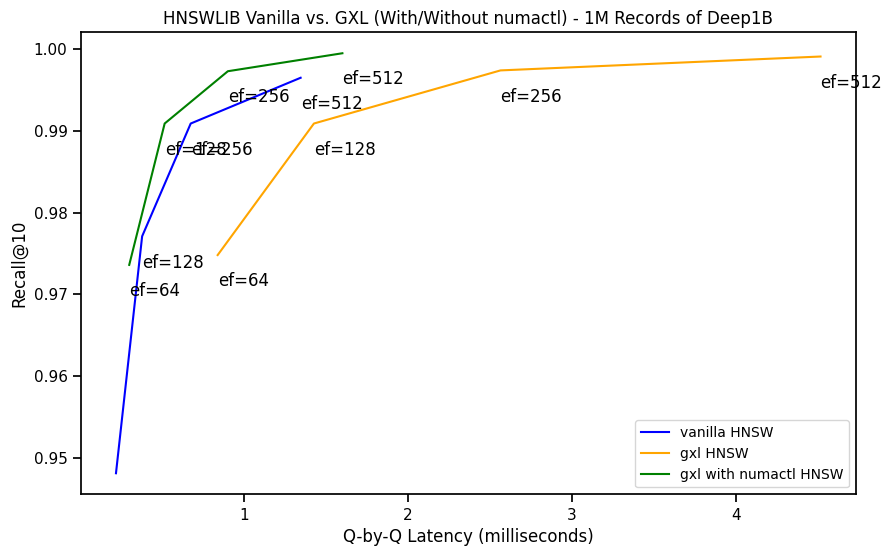

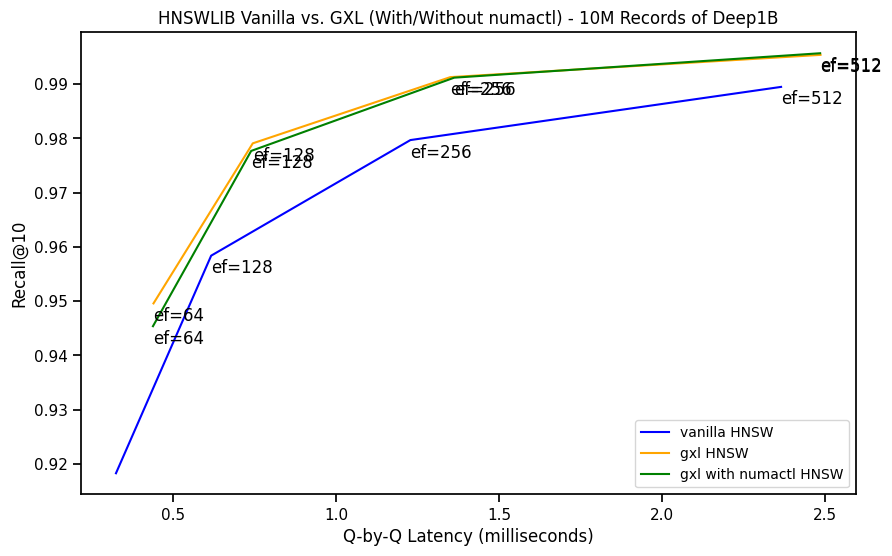

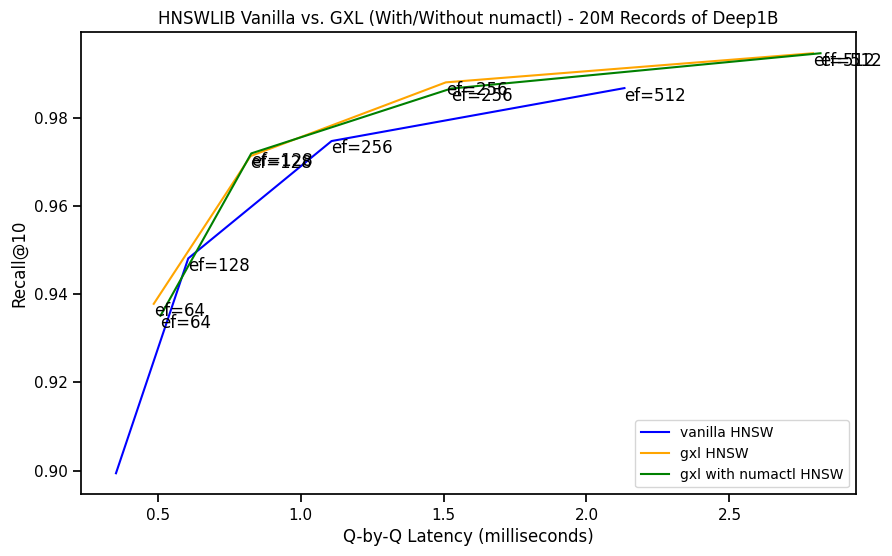

In [48]:
lst = ['1M', '10M', '20M']
for i in lst:
    plot_paretto(i)

  numrecs  ef_search  recall@10   latency
0    100M         64     0.8562  0.448322
1    100M        128     0.9160  0.798294
2    100M        256     0.9549  1.545902
3    100M        512     0.9766  3.134926
   numrecs  ef_search  recall@10    latency
12    100M         64     0.9016   1.382641
13    100M        128     0.9495   2.073825
14    100M        256     0.9752   4.792348
15    100M        512     0.9885  12.528867
[0.448322, 0.798294, 1.545902, 3.1349260000000005] [0.8562000000000001, 0.916, 0.9549000000000001, 0.9766000000000001]
[1.382641, 2.0738250000000003, 4.792348, 12.528867] [0.9016000000000001, 0.9495, 0.9752000000000001, 0.9885]
  numrecs  ef_search  recall@10   latency
4    500M         64     0.8178  0.592424
5    500M        128     0.8895  1.043490
6    500M        256     0.9345  1.725724
7    500M        512     0.9614  3.021589
   numrecs  ef_search  recall@10    latency
20    500M         64     0.8522   3.439807
21    500M        128     0.9137   3.964375


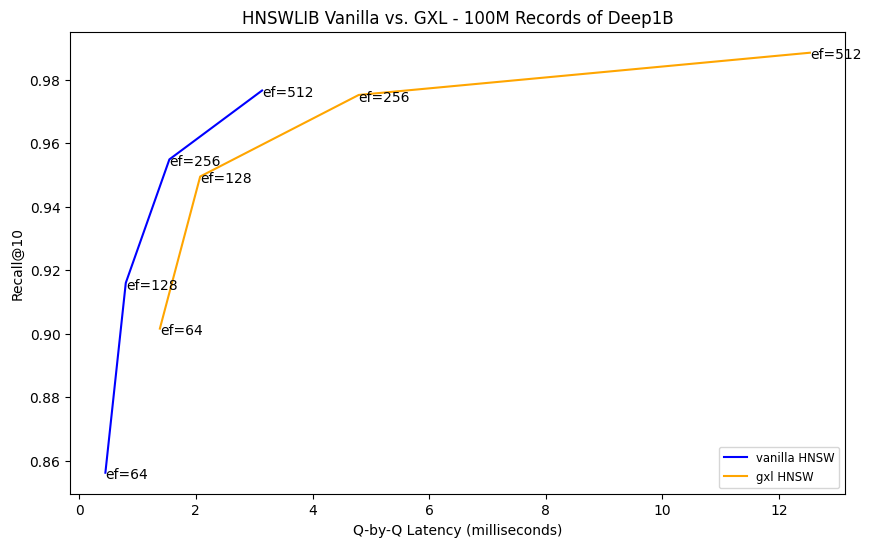

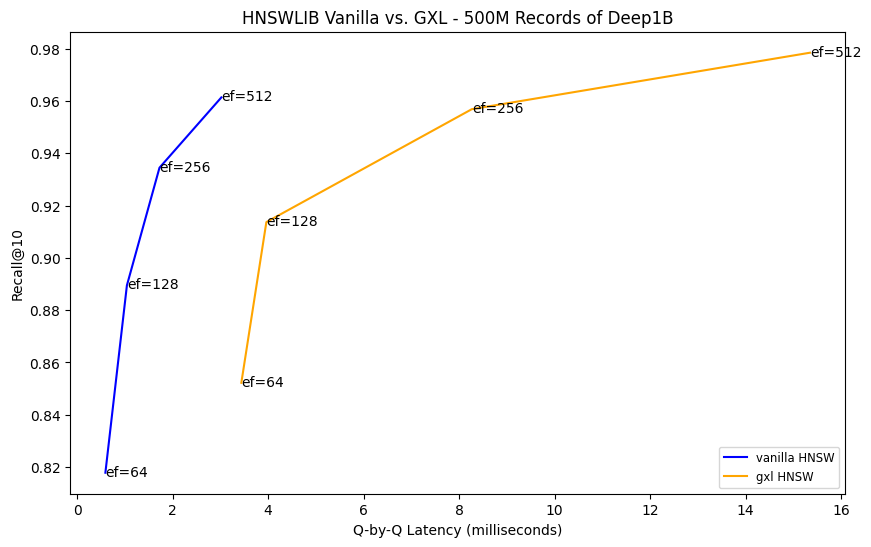

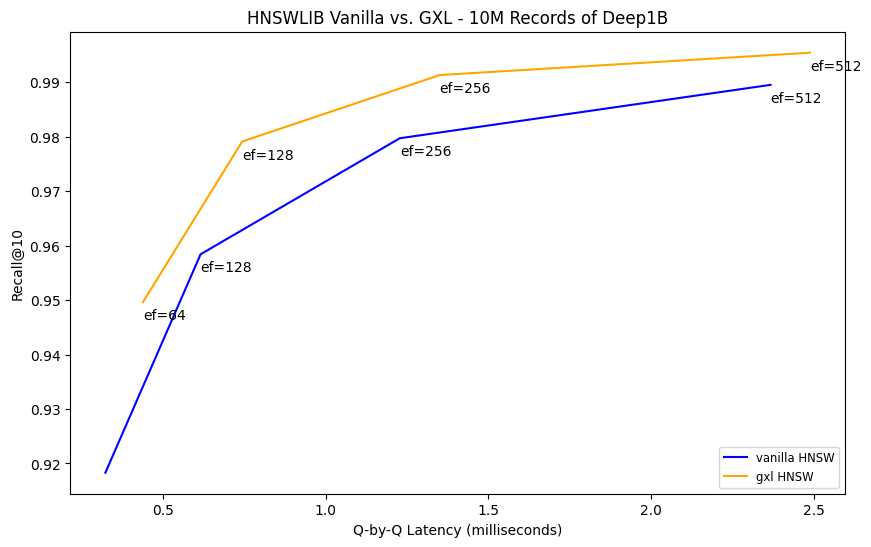

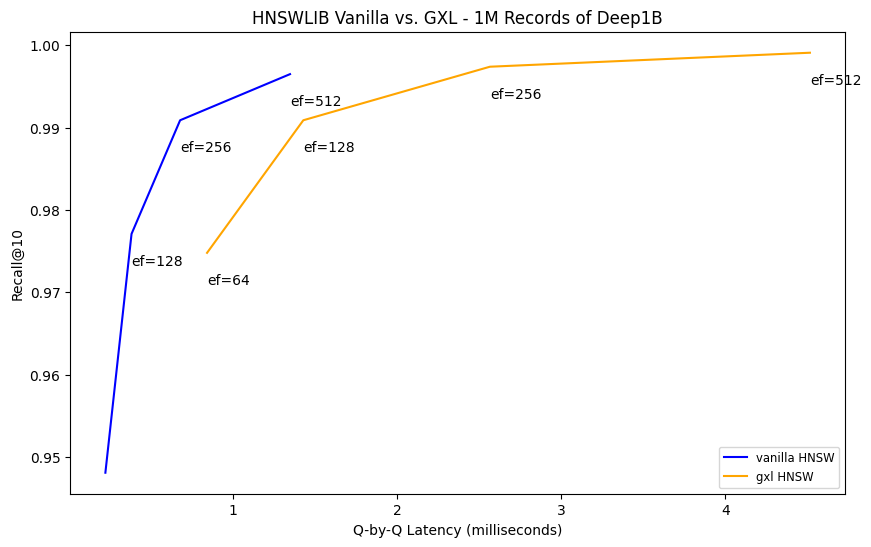

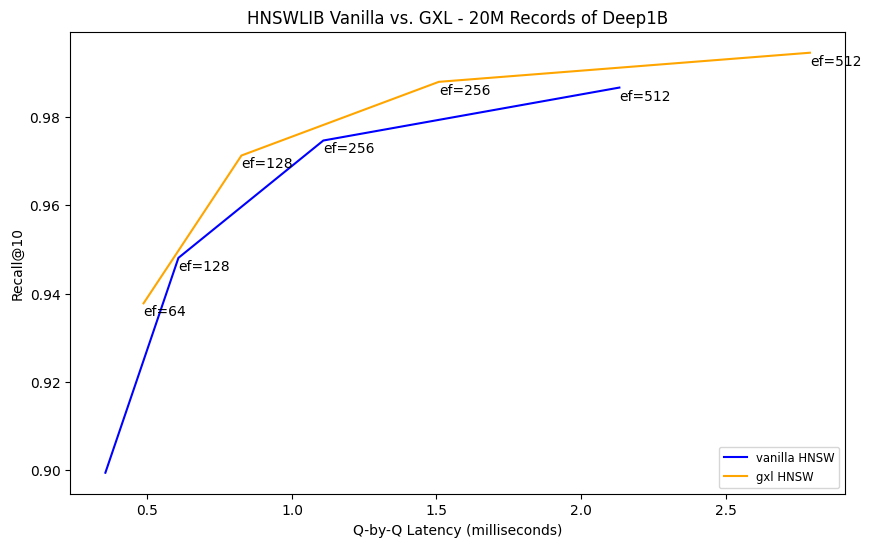

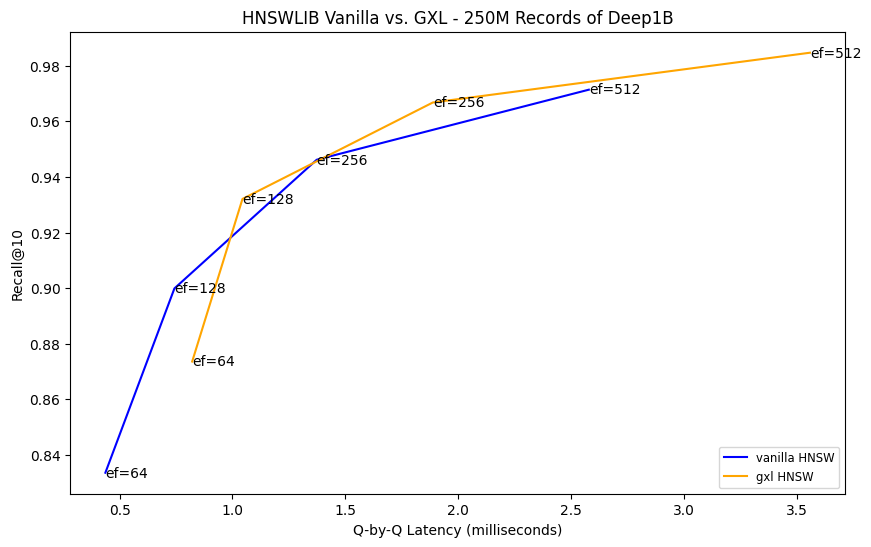

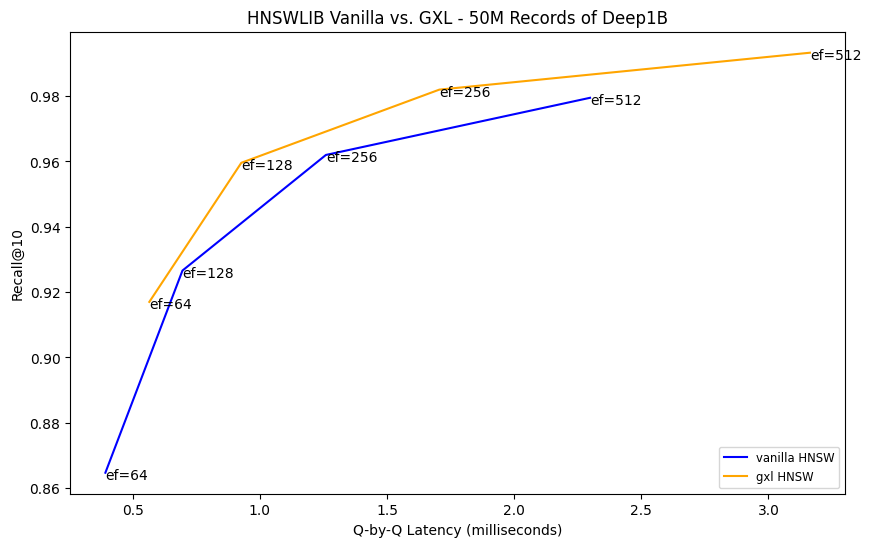

In [14]:
for i in vanilla_result_df.numrecs.unique():
    plot_paretto(i)

# plot search time

vanilla search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.65513025, 1.1334072499999999, 1.0507327499999999, 1.161586, 1.481861, 1.283125, 1.59580675]


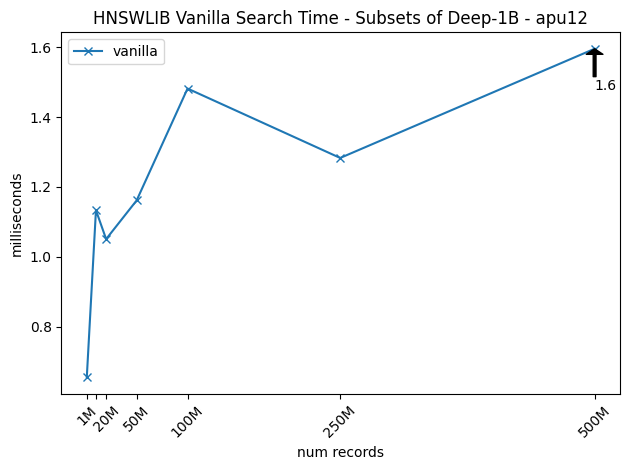

In [15]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_walltime = \
    vanilla_df[vanilla_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    #y = avg_search_wall_import_time[idx]/(1000*60.0*60.0) # milliseconds
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_walltime.png")

gxl search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [6.492006944444445e-07, 3.486188888888889e-07, 3.897030555555556e-07, 4.4175604166666664e-07, 1.442894513888889e-06, 5.078859722222221e-07, 2.1542512500000003e-06]


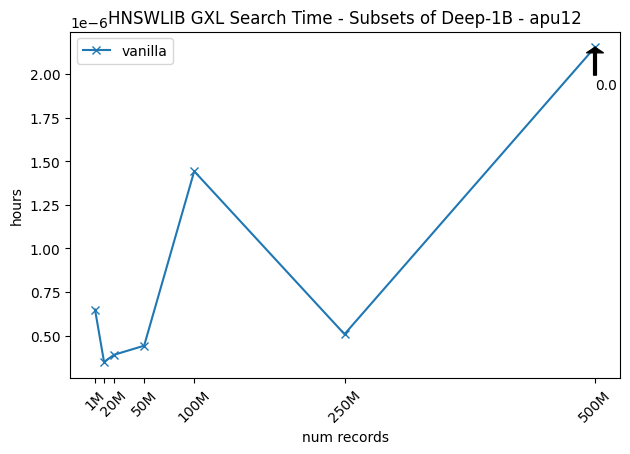

In [16]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_wall_time = \
    gxl_df[gxl_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_wall_time.index:
    x = idx
    xs.append(x)
    y = avg_search_wall_time[idx]/(1000*60.0*60.0)
    ys.append(y)
print("gxl search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB GXL Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_hnswlib_search_walltime.png")

# plot build/load time

vanilla search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.0020208841666666667, 0.02659379277777778, 0.05748090527777778, 0.16004222916666666, 0.33805636916666665, 0.9142767616666667, 2.0894956697222224]


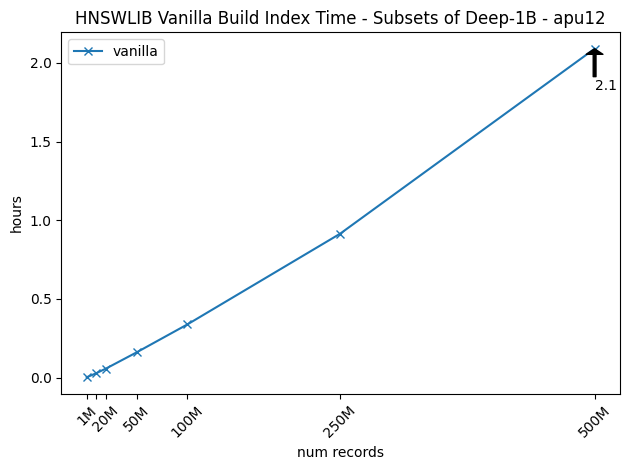

In [17]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_wall_import_time = \
    vanilla_df[vanilla_df['operation'] == 'build'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_wall_import_time.index:
    x = idx
    xs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Build Index Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_walltime_build.png")

vanilla search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.65513025, 1.1334072499999999, 1.0507327499999999, 1.161586, 1.481861, 1.283125, 1.59580675]


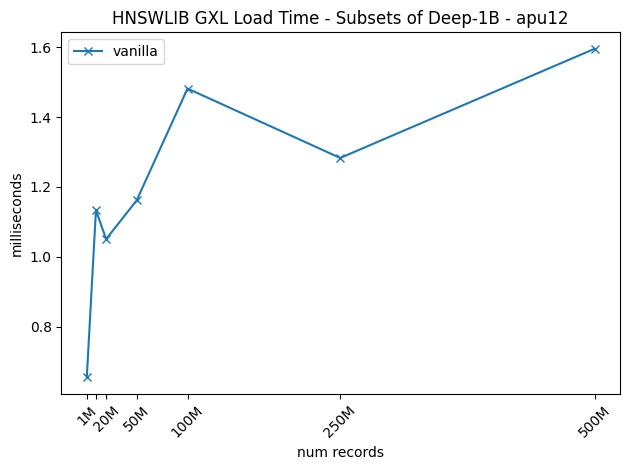

In [18]:
# Plot walltime

# compute average search walltime via groupby
avg_search_wall_time = \
    gxl_df[gxl_df['operation'] == 'load'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

ax.set_title("HNSWLIB GXL Load Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_load_walltime.png")

# Import GXL Index Build Time

In [49]:
GXL_PATH = "/mnt/nas1/GXL/deep1B/v2.0_with250Mfix"
NUMACTL_PATH = "/tmp/gxl_1701298133"

In [20]:
# Load CSV
gxl_index_csvs = []

for file in os.listdir(GXL_PATH):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(GXL_PATH, file)
        gxl_index_csvs.append(fpath)

if len(gxl_index_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for gxl index build" % len(gxl_index_csvs))


deep1B_1m_ef_64_M_32_gxl.bin
deep1B_10m_ef_64_M_32_gxl.bin
deep1B_20m_ef_64_M_32_gxl.bin
deep1B_50m_ef_64_M_32_gxl.bin
deep1B_100m_ef_64_M_32_gxl.bin
deep1B_250m_ef_64_M_32_gxl.bin
deep-1M_1700158142.098489.csv
deep-10M_1700158355.068015.csv
deep-20M_1700158661.755577.csv
deep-50M_1700159398.912206.csv
deep-100M_1700160637.835966.csv
deep-250M_1700163449.826781.csv
deep1B_500m_ef_64_M_32_gxl.bin
deep-500M_1700773991.855970.csv
found 7 CSV files for gxl index build


In [50]:
# Load CSV numactl
gxl_numactl_index_csvs = []

for file in os.listdir(NUMACTL_PATH):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(NUMACTL_PATH, file)
        gxl_numactl_index_csvs.append(fpath)

if len(gxl_numactl_index_csvs)==0:
    raise Exception("No CSVs found in NUMACTL GXL!")
print("found %d CSV files for gxl index build" % len(gxl_numactl_index_csvs))


deep1B_20m_ef_64_M_32_gxl.bin
deep-20M_1701298725.630955.csv
deep1B_10m_ef_64_M_32_gxl.bin
deep-10M_1701298377.557637.csv
deep-1M_1701298162.210245.csv
deep-10M.log
deep-20M.log
deep1B_1m_ef_64_M_32_gxl.bin
deep-1M.log
found 3 CSV files for gxl index build


In [21]:
# Load to df
gxl_index_dfs = []

for csv in gxl_index_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_index_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
gxl_index_df = pd.concat( gxl_index_dfs )
print("There are %d rows" % gxl_index_df.shape[0])
gxl_index_df.head()

Concatenating into one master dataframe...
There are 35 rows


,Unnamed: 0,operation,subop,numboards,board_details,version,start,end,walltime,dataset
0,0,ledainfo,boards,4.0,"[""\x1b[1m\x1b[33mslot0\x1b[0m {'Apuc_Mask': '0...",NaN,NaN,NaN,NaN,deep-1M
1,1,build-index,cen_gen,NaN,NaN,GXL version 2.0,2023-11-16 10:08:33.552025,2023-11-16 10:08:41.556780,8.004755,deep-1M
2,2,build-index,knn_gen,NaN,NaN,GXL version 2.0,2023-11-16 10:08:41.556829,2023-11-16 10:09:00.434040,18.877211,deep-1M
3,3,build-index,knn_symmetric,NaN,NaN,GXL version 2.0,2023-11-16 10:09:00.434087,2023-11-16 10:09:01.153263,0.719176,deep-1M
4,4,build-index,index_gen,NaN,NaN,exesize=104096,2023-11-16 10:09:01.153309,2023-11-16 10:09:02.092263,0.938954,deep-1M


In [51]:
# Load to df numactl
gxl_numactl_index_dfs = []

for csv in gxl_numactl_index_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_numactl_index_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
gxl_numactl_index_df = pd.concat( gxl_numactl_index_dfs )
print("There are %d rows" % gxl_numactl_index_df.shape[0])
gxl_numactl_index_df.head()

Concatenating into one master dataframe...
There are 15 rows


,Unnamed: 0,operation,subop,numboards,board_details,cpunodebind,preferred,version,start,end,walltime,dataset
0,0,ledainfo,boards,4.0,"[""\x1b[1m\x1b[33mslot0\x1b[0m {'Apuc_Mask': '0...",1,1,NaN,NaN,NaN,NaN,deep-20M
1,1,build-index,cen_gen,NaN,NaN,1,1,GXL version 2.0,2023-11-29 14:54:13.768373,2023-11-29 14:55:36.489548,82.721175,deep-20M
2,2,build-index,knn_gen,NaN,NaN,1,1,GXL version 2.0,2023-11-29 14:55:36.489583,2023-11-29 14:58:16.310710,159.821127,deep-20M
3,3,build-index,knn_symmetric,NaN,NaN,1,1,GXL version 2.0,2023-11-29 14:58:16.310760,2023-11-29 14:58:32.674432,16.363672,deep-20M
4,4,build-index,index_gen,NaN,NaN,1,1,exesize=104096,2023-11-29 14:58:32.674468,2023-11-29 14:58:45.623095,12.948627,deep-20M


In [22]:
g_df = gxl_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds
g_df = g_df[g_df['operation'] == 'build-index']
g_df['numrecs'] = g_df['dataset'].apply(lambda x: size_num(x[5:]))
g_df.head()

,operation,subop,walltime,dataset,numrecs
1,build-index,cen_gen,8.004755,deep-1M,1000000
2,build-index,knn_gen,18.877211,deep-1M,1000000
3,build-index,knn_symmetric,0.719176,deep-1M,1000000
4,build-index,index_gen,0.938954,deep-1M,1000000
1,build-index,cen_gen,44.826533,deep-10M,10000000


In [23]:
g_pivot = pd.pivot_table(data=g_df, index=['numrecs'], columns=['subop'], values='walltime')
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric
numrecs,,,,
1000000,8.004755,0.938954,18.877211,0.719176
10000000,44.826533,11.759718,83.071893,7.102119
20000000,82.985654,21.666023,165.239255,14.505771
50000000,218.629373,56.033163,394.741625,42.915334
100000000,238.232299,105.779660,767.895688,101.182567
250000000,349.322762,297.052899,1903.636211,227.800315
500000000,689.964442,595.208836,3834.971609,475.139651


In [52]:
g_numactl_df = gxl_numactl_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds
g_numactl_df = g_numactl_df[g_numactl_df['operation'] == 'build-index']
g_numactl_df['numrecs'] = g_numactl_df['dataset'].apply(lambda x: size_num(x[5:]))
g_numactl_df.head()

,operation,subop,walltime,dataset,numrecs
1,build-index,cen_gen,82.721175,deep-20M,20000000
2,build-index,knn_gen,159.821127,deep-20M,20000000
3,build-index,knn_symmetric,16.363672,deep-20M,20000000
4,build-index,index_gen,12.948627,deep-20M,20000000
1,build-index,cen_gen,45.588779,deep-10M,10000000


In [58]:
g_numactl_pivot = pd.pivot_table(data=g_numactl_df, index=['numrecs'], columns=['subop'], values='walltime')

g_numactl_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()[:3]
g_numactl_pivot['total'] = g_numactl_pivot.iloc[:, -5:-1].sum(axis=1)
g_numactl_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla,total
numrecs,,,,,,
1000000,5.637472,0.666624,15.243185,0.827737,7.275183,22.375018
10000000,45.588779,6.369654,85.323818,8.092174,95.737654,145.374425
20000000,82.721175,12.948627,159.821127,16.363672,206.931259,271.854601


In [54]:
v_df = vanilla_df[['operation', 'walltime', 'dataset', 'numrecs']] # seconds
v_df = v_df[v_df['operation'] == 'build']
v_df

,operation,walltime,dataset,numrecs
0,build,1217.002929,deep-100M,100000000
0,build,7522.184411,deep-500M,500000000
0,build,95.737654,deep-10M,10000000
0,build,7.275183,deep-1M,1000000
0,build,206.931259,deep-20M,20000000
0,build,3291.396342,deep-250M,250000000
0,build,576.152025,deep-50M,50000000


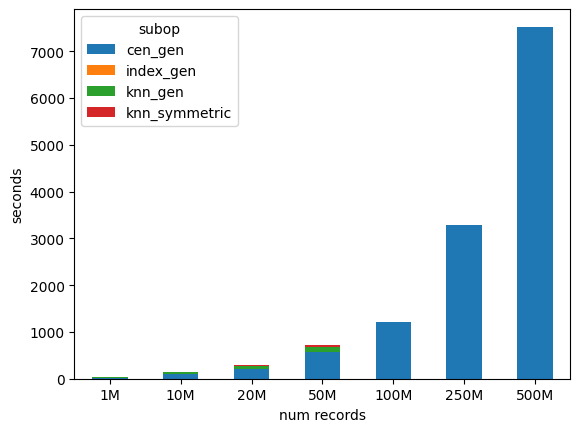

In [26]:

fig, ax = plt.subplots()

g_pivot.plot(kind='bar', stacked=True, ax=ax)
v_df.sort_values(['numrecs'])['walltime'].plot(kind='bar', ax=ax)
plt.ylabel('seconds')
plt.xlabel('num records')

plt.xticks(np.arange(7), ['1M', '10M', '20M', '50M', '100M', '250M', '500M'], rotation=360)

plt.show()


In [27]:
g_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla
numrecs,,,,,
1000000,8.004755,0.938954,18.877211,0.719176,7.275183
10000000,44.826533,11.759718,83.071893,7.102119,95.737654
20000000,82.985654,21.666023,165.239255,14.505771,206.931259
50000000,218.629373,56.033163,394.741625,42.915334,576.152025
100000000,238.232299,105.779660,767.895688,101.182567,1217.002929
250000000,349.322762,297.052899,1903.636211,227.800315,3291.396342
500000000,689.964442,595.208836,3834.971609,475.139651,7522.184411


In [28]:
g_pivot['total'] = g_pivot.iloc[:, -5:-1].sum(axis=1)
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla,total
numrecs,,,,,,
1000000,8.004755,0.938954,18.877211,0.719176,7.275183,28.540096
10000000,44.826533,11.759718,83.071893,7.102119,95.737654,146.760263
20000000,82.985654,21.666023,165.239255,14.505771,206.931259,284.396703
50000000,218.629373,56.033163,394.741625,42.915334,576.152025,712.319495
100000000,238.232299,105.779660,767.895688,101.182567,1217.002929,1213.090214
250000000,349.322762,297.052899,1903.636211,227.800315,3291.396342,2777.812187
500000000,689.964442,595.208836,3834.971609,475.139651,7522.184411,5595.284538


/tmp/ipykernel_3504655/2233567472.py:34: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon,


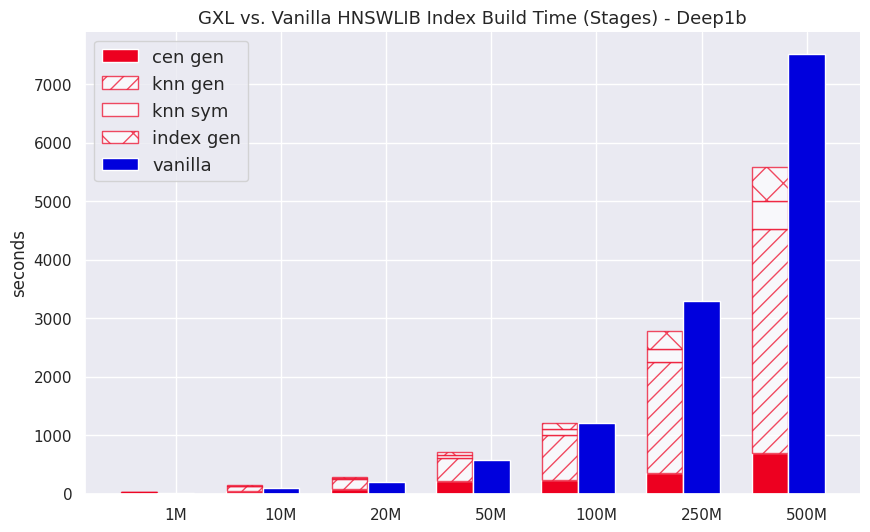

In [29]:
import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist())
gxl_index_gen = np.array(g_pivot.index_gen.tolist())
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist())
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())
# vanilla
vanilla_time = np.array(g_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M', '500M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL vs. Vanilla HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()



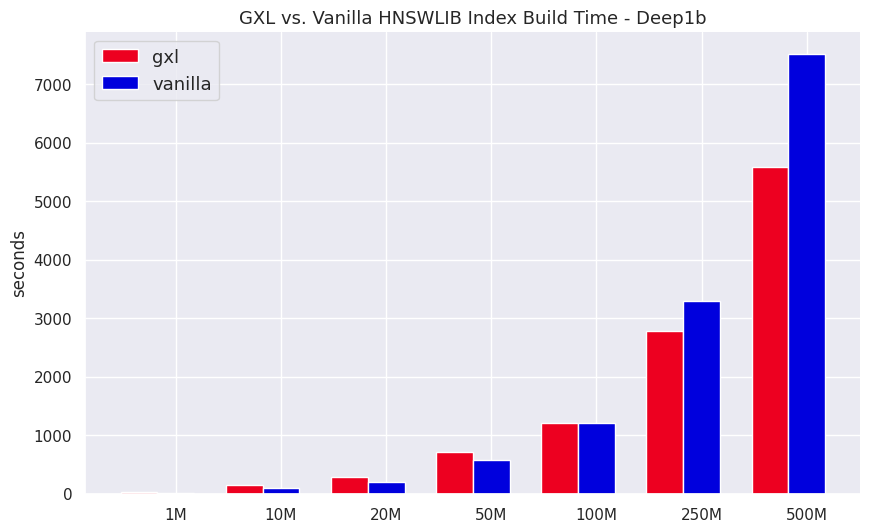

In [30]:
import seaborn as sns

# data
# gxl
gxl_time = np.array(g_pivot.total.tolist())
# vanilla
vanilla_time = np.array(g_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M', '500M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_time, bar_width, color='#ED0020', label='gxl')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    plt.title('GXL vs. Vanilla HNSWLIB Index Build Time - Deep1b', fontsize=13)
    sns.despine()

    plt.savefig('results/vis/gxl_vanilla_index_build_time.png', bbox_inches="tight")
    plt.show()



# numactl
## gxl with numactl vs vanilla

/tmp/ipykernel_3504655/2503105408.py:34: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon,


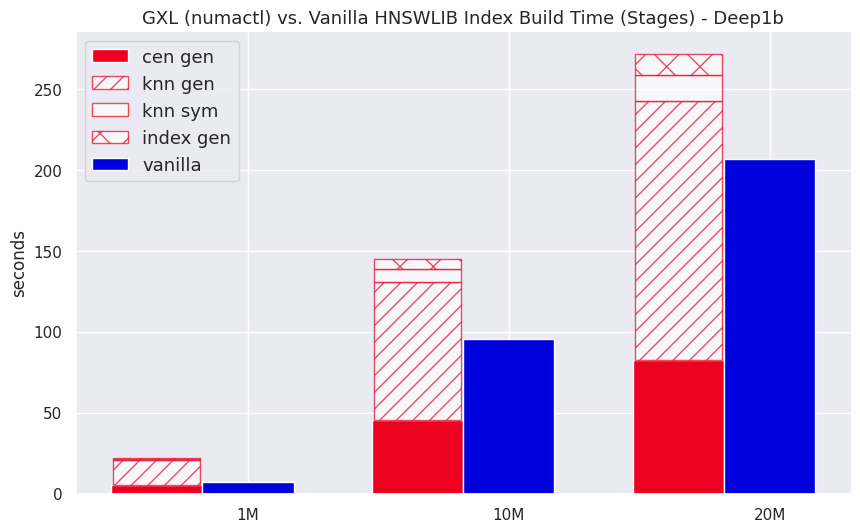

In [59]:
import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())
gxl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())
gxl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())
gxl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())
# vanilla
vanilla_time = np.array(g_numactl_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL (numactl) vs. Vanilla HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_numactl_vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()



## gxl with vs without numactl

/tmp/ipykernel_3504655/1458252558.py:39: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon,
/tmp/ipykernel_3504655/1458252558.py:54: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_numactl_knn_sym = plt.bar(v_pos, gxl_numactl_knn_sym, bar_width-epsilon,


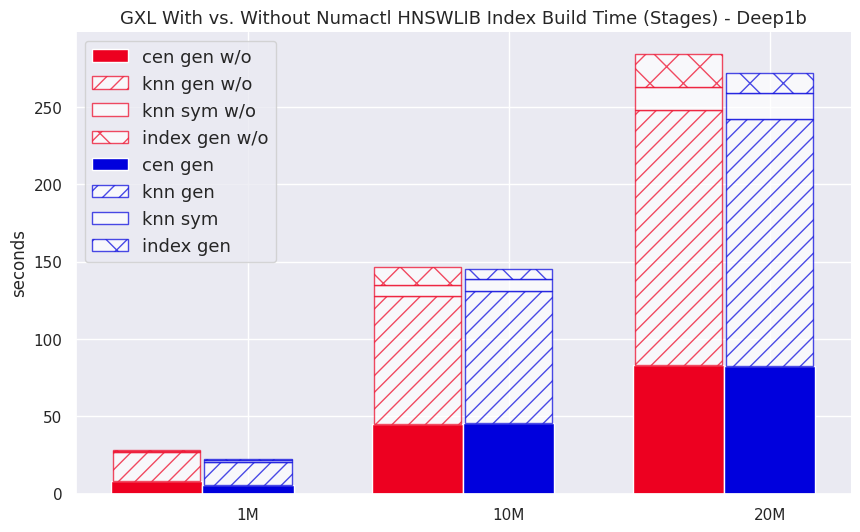

In [63]:
import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist())[:3]
gxl_index_gen = np.array(g_pivot.index_gen.tolist())[:3]
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist())[:3]
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())[:3]

# gxl numactl
gxl_numactl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())
gxl_numactl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())
gxl_numactl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())
gxl_numactl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())

# data sizes
sizes = ['1M', '10M', '20M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen w/o')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen w/o')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym w/o')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen w/o')

    # numactl
    stacked_gxl_numactl_cen_gen = plt.bar(v_pos, gxl_numactl_cen_gen, bar_width, color='#0000DD', label='cen gen')

    stacked_gxl_numactl_knn_gen = plt.bar(v_pos, gxl_numactl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_numactl_knn_sym = plt.bar(v_pos, gxl_numactl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_numactl_knn_gen+gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_numactl_idx_gen = plt.bar(v_pos, gxl_numactl_index_gen, bar_width-epsilon, 
                            bottom=gxl_numactl_knn_sym+gxl_numactl_knn_gen+gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='x', label='index gen')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL With vs. Without Numactl HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_numactl_with_without_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

